In [11]:
import numpy as np 
import pandas as pd 
import os

from sklearn.model_selection import train_test_split
import torch
from PIL import Image , ImageOps
from torchvision import transforms
from torch.utils.data import Dataset , DataLoader, random_split

import matplotlib.pyplot as plt

import imageio

In [12]:
file_names = []
directory = '/kaggle/input/nih-deeplesion-subset/minideeplesion'

train_size = 10000
val_size = 500
test_size = 1000

total_size = train_size + val_size + test_size

for direc in os.listdir(directory):
    if len(file_names) >= total_size:
        break
    for file in os.listdir(directory + '/' + direc):
        if len(file_names) >= total_size:
            break
        if (file.endswith(".png")):
            image_path = directory + '/' + direc + '/' + file
            file_names.append(image_path)


print(f'Number of data : {len(file_names)}')

data_train_temp, data_test = train_test_split(file_names, test_size = test_size, random_state=42)
data_train, data_valid = train_test_split(data_train_temp, test_size = val_size, random_state=42)

print(f'Number of train data : {len(data_train)}')
print(f'Number of validation data : {len(data_valid)}')
print(f'Number of test data : {len(data_test)}')

Number of data : 11500
Number of train data : 10000
Number of validation data : 500
Number of test data : 1000


In [13]:
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class CustomDataset(Dataset):
    def __init__(self, images, image_size ,crop = True, Augmentation = True , scale = 2):
        self.images = images
        self.image_size = image_size
        self.crop = crop
        self.Augmentation = Augmentation
        self.rotation_angles = [90, 180, 270]
        self.scale = scale
        self.LR_size = int(image_size/scale)

        self.augmentation = transforms.Compose([
            transforms.RandomHorizontalFlip(),
        ])
        
            
        self.crop = transforms.Compose([
            transforms.RandomCrop(self.image_size),
        ]) 

#         self.original_transform = transforms.Compose([

#         ])
            
        self.downsize_transform = transforms.Compose([
            transforms.Resize((self.LR_size) , interpolation=Image.BICUBIC, antialias=True),
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path)
       
        # Apply rotation randomly
        if self.Augmentation:
            angle = np.random.choice(self.rotation_angles)
            image = transforms.functional.rotate(image, int(angle))
            image = self.augmentation(image)
        
        image = transforms.ToTensor()(image)
        image = (image  - torch.min(image)) / (torch.max(image)  - torch.min(image))
  
    
        if self.crop:
            image = self.crop(image)
        output_image = image
        input_image = self.downsize_transform(image)
        

        return input_image, output_image


In [14]:
train_dataset = CustomDataset(data_train , image_size = 96 )
train_dataloader = DataLoader(train_dataset, batch_size= 8, shuffle=True)

valid_dataset = CustomDataset(data_valid, image_size = 96, Augmentation = False)
valid_dataloader = DataLoader(valid_dataset, batch_size= 8, shuffle=False)

test_dataset = CustomDataset(data_test, image_size = 512, Augmentation = False , crop = False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [15]:
x , y = next(iter(test_dataloader))
x.shape

torch.Size([1, 1, 256, 256])

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class ID(nn.Module):
    """
    Information Distillation block.
    
    Args:
        in_channels: number of input channels (and output!).
    """
    
    def __init__(self, in_channels):
        super(ID, self).__init__()
        # Split channels
        self.split_channels1 = in_channels // 2
        self.split_channels2 = self.split_channels1 // 2
        self.split_channels3 = self.split_channels2 // 2
        self.split_channels  = self.split_channels1 + self.split_channels2 + self.split_channels3 * 2
        
        # 1x1 and 3x3 convolution layers
        self.conv1x1_1 = nn.Conv2d(self.split_channels1, self.split_channels1, kernel_size=1)
        self.conv1x1_2 = nn.Conv2d(self.split_channels2, self.split_channels2, kernel_size=1)
        self.conv1x1_3 = nn.Conv2d(self.split_channels3, self.split_channels3, kernel_size=1)
        
        self.conv3x3_1 = nn.Conv2d(self.split_channels1, self.split_channels1, kernel_size=3, padding=1)
        self.conv3x3_2 = nn.Conv2d(self.split_channels2, self.split_channels2, kernel_size=3, padding=1)
        self.conv3x3_3 = nn.Conv2d(self.split_channels3, self.split_channels3, kernel_size=3, padding=1)
        self.conv3x3_4 = nn.Conv2d(self.split_channels3, self.split_channels3, kernel_size=3, padding=1)
        
        # Final 1x1 convolution layer
        self.final_conv1x1 = nn.Conv2d(self.split_channels, in_channels, kernel_size=1)
        
        # ReLU activation
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        """
        distilled_i : i-th distilled feature (preserved)
        coarse_i    : i-th coarse feature (requires further processing)

        Args:
            x: input feature
        Returns:
            id_out: output feature
        """
        
        # First distillation step
        x1, x2      = torch.split(x, self.split_channels1, dim=1)
        distilled_1 = self.conv1x1_1(x1)
        coarse_1    = self.relu(self.conv3x3_1(x2) + x2)
        
        # Second distillation step
        x1, x2      = torch.split(coarse_1, self.split_channels2, dim=1)
        distilled_2 = self.conv1x1_2(x1)
        coarse_2    = self.relu(self.conv3x3_2(x2) + x2)        
        
        # Third distillation step
        x1, x2      = torch.split(coarse_2, self.split_channels3, dim=1)
        distilled_3 = self.conv1x1_3(x1)
        coarse_3    = self.relu(self.conv3x3_3(x2) + x2)        
        
        # Final extraction
        distilled_4 = self.conv3x3_4(coarse_3)
        
        # Concatenate all features
        f_distilled = torch.cat([distilled_1, distilled_2, distilled_3, distilled_4], dim=1)
        # Final 1x1 convolution to fuse the features
        id_out = self.final_conv1x1(f_distilled)
        
        return id_out
    



class MAB(nn.Module):
    """
    Multi-Scale Attention Block.
    
    Args:
        in_chnnels: number of input channels (and output!).
        r: reduction factor of 1x1 convolutions (channel down-sampling an up-sampling).
        n: number of branches.
        kn: lernel size of feature extractor convolutions in each branch (knxkn Conv).
    """

    def __init__(self, in_channels:int, r:int, n:int, kn:list)->None:
        super().__init__()
        
        self.branches = nn.ModuleList()
        for i in range(n):
            kernel_size = kn[i]
            padding = kernel_size // 2
            
            branch = nn.Sequential(
                nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
                nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, padding=padding),
                nn.Conv2d(in_channels, in_channels // r, kernel_size=1), # WD: channel down-sampling
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels // r, in_channels, kernel_size=1), # WU: channel up-sampling
                nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, padding=padding)
            )
            
            self.branches.append(branch)
    
    def forward(self, x:torch.Tensor)->torch.Tensor:
        branch_outputs = []
        
        for branch in self.branches:
            branch_outputs.append(branch(x))
        
        combined_output = sum(branch_outputs)
        sigmoid_output  = torch.sigmoid(combined_output)
        mab_out         = sigmoid_output * x # Element-wise multiplication
        
        return mab_out



class IDMAB(nn.Module):
    def __init__(self, in_channels, param):
        super(IDMAB, self).__init__()
        self.id = ID(in_channels)
        self.mba = MAB(in_channels, param.mba_r, param.mba_n, param.mba_kn)

    def forward(self, x):
        x_in = x
        id_out = self.id(x)
        mba_out = self.mba(id_out)
        return mba_out + x_in
    

class IDMAG(nn.Module):
    def __init__(self, param):
        super(IDMAG, self).__init__()
        self.idmab_modules = nn.ModuleList([IDMAB(param.num_features, param) for _ in range(param.B)])
        self.conv = nn.Conv2d(param.num_features, param.num_features, kernel_size=3, padding=1)

    def forward(self, x):
        x_in = x
        for idmab_module in self.idmab_modules:
            x = idmab_module(x)
        x = self.conv(x)
        x = x + x_in
        return x


class DFES(nn.Module):
    def __init__(self,param):
        super(DFES, self).__init__()
        self.idmag_modules = nn.ModuleList([IDMAG(param) for _ in range(param.G)])
        self.conv = nn.Conv2d(param.num_features, param.num_features, kernel_size=3, padding=1)

    def forward(self, x):
        x_in = x
        for idmag_module in self.idmag_modules:
            x = idmag_module(x)
        x = self.conv(x)
        x = x + x_in
        return x
    
class SFES(nn.Module):
    def __init__(self, num_input, num_features):
        super(SFES, self).__init__()

        self.conv = nn.Conv2d(num_input, num_features, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv(x)
        return x

class PixelShuffle(nn.Module):
    def __init__(self, input_channel , upscale_factor):
        super(PixelShuffle, self).__init__()
        self.upscale_factor = upscale_factor
        self.conv1 = nn.Conv2d(input_channel, input_channel * (upscale_factor**2) , kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        batch_size, channels, height, width = x.size()
        r = self.upscale_factor

        output_channels = channels // (r ** 2)
        output_height = height * r
        output_width = width * r

        # Reshape  (batch_size, channels , height, width) -----> channels : output_channels * r * r ----->  (batch_size, output_channels, r, r, height, width)
        x = x.reshape(batch_size, output_channels, r, r, height, width)

        # Permute to (batch_size, output_channels, height, r, width, r)
        x = x.permute(0, 1, 4, 2, 5, 3)

        # Reshape to (batch_size, output_channels, output_height, output_width)
        x = x.reshape(batch_size, output_channels, output_height, output_width)

        return x
    

class ReconstructionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ReconstructionBlock, self).__init__()
        self.FB = FeedbackBlock( in_channels, out_channels)
        self.conv = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        x = self.FB(x)
        x = self.conv(x)
        return x


class FeedbackBlock(nn.Module):
    def __init__(self, in_channels, out_channels, maxIter=10):
        super(FeedbackBlock, self).__init__()
        self.conv0 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv  = nn.Conv2d(in_channels + out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.maxIter = maxIter
    
    def forward(self, x):
        all_x = [x]
        x0 = x

        x = self.conv0(x0)
        all_x.append(x)

        for i in range(self.maxIter):
          x_pre = x
          x = self.conv(torch.cat([x0, x], dim=1))
          all_x.append(x)

          if (torch.sum(torch.abs(x - x_pre))) < 1:
            break

        x = self.relu(x)

        return x #, all_x

        


class IDMAN(nn.Module):
    def __init__(self, param):
        super(IDMAN, self).__init__()
        self.SFES = SFES(param.num_input, param.num_features)
        self.DFES = DFES(param)
        self.UP = PixelShuffle(param.num_features, 2)
        self.RB = ReconstructionBlock(param.num_features, 1)


    def forward(self, x):
        x = self.SFES(x)
        x = self.DFES(x)
        x = self.UP(x)
        x = self.RB(x)
        return x

class params():
    def __init__(self, num_input, num_features, B, G, mba_r, mba_n, mba_kn):
        self.num_input = num_input
        self.num_features = num_features
        self.B = B
        self.G = G
        self.mba_r = mba_r
        self.mba_n = mba_n
        self.mba_kn = mba_kn




In [17]:
parameters = params(num_input=1, num_features=16, B=10, G=5, mba_r=16, mba_n=2, mba_kn=[3,5])
model = IDMAN(parameters)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print()

lossfun = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.99)


In [18]:
model.RB.FB.maxIter

10

In [19]:
import numpy as np
import sys
import time
from matplotlib import pyplot as plt
import torch

def train(model, device, train_loader, valid_loader, lossfun, optimizer, scheduler, epoch_number=15, 
          save_model=False, model_name='Unknown', visualization=True):
  
  loss_train_epoch = []  # List to store training losses for each epoch
  loss_valid_epoch = []  # List to store validation losses for each epoch


  training_time = 0      # Variable to track total training time

  model.to(device)       # Move the model to the specified device (GPU or CPU)

  for epoch in range(epoch_number):
    loss_train_batch = 0   # Variable to accumulate training loss for each batch
    acc_train_batch = 0    # Variable to accumulate training accuracy for each batch
    num_train_batches = 0 # Total number of batches in training set

    # Training loop
    model.train()  # Set the model to train mode
    for X, Y in train_loader:
      X = X.to(device)  # Move input data to the specified device
      Y = Y.to(device)  # Move target labels to the specified device

      start_time = time.time()  # Record start time for batch processing
      yHat = model(X)        # Forward pass
      loss = lossfun(yHat, Y)  # Calculate loss
      
      optimizer.zero_grad()  # Clear gradients of optimizer
      loss.backward()         # Backpropagation
      optimizer.step()        # Update weights

      loss_train_batch += loss.item()  # Accumulate training loss
      num_train_batches += 1  # Increment the number of batches processed
      stop_time = time.time()   # Record stop time for batch processing
      training_time += (stop_time - start_time)  # Accumulate batch processing time
      moving_batch_loss = loss_train_batch / num_train_batches
      sys.stdout.write('\r' + f'epoch = {epoch + 1} , batch = {num_train_batches}, loss Train = {moving_batch_loss:.4f}')

    loss_train_epoch.append(moving_batch_loss)  # Calculate average training loss for epoch
    scheduler.step()  # Adjust learning rate scheduler
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
      loss_valid_batch = 0   # Variable to accumulate validation loss for each batch
      acc_valid_batch = 0    # Variable to accumulate validation accuracy for each batch
      num_valid_batches = 0  # Total number of batches in validation set

      for X, Y in valid_loader:
        X = X.to(device)   # Move input data to the specified device
        Y = Y.to(device)   # Move target labels to the specified device

        yHat = model(X)    # Forward pass
        loss = lossfun(yHat, Y)  # Calculate loss

        loss_valid_batch += loss.item()  # Accumulate validation loss
        num_valid_batches += 1  # Increment the number of batches processed
        moving_batch_loss = loss_valid_batch / num_valid_batches
    loss_valid_epoch.append(moving_batch_loss)  # Calculate average validation loss for epoch

    # Print progress
    print('\r' + f'epoch = {epoch + 1}, loss Train = {loss_train_epoch[-1]:.4f}, loss Valid = {loss_valid_epoch[-1]:.4f}')

  if save_model:
    PATH = model_name + '.pth'
    # https://pytorch.org/tutorials/beginner/saving_loading_models.html
    torch.save(model, PATH) # Save model parameters to file
    
  print()   # Print newline for better readability
  print(f'Training took {training_time:.4f} seconds')  # Print total training time

  if visualization:
    # Plot training and validation loss
    plt.figure()
    plt.plot(np.arange(epoch_number), loss_train_epoch, '-*', color='blue', label='Train')
    plt.plot(np.arange(epoch_number), loss_valid_epoch, '-o', color='orange', label='Validation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title(f'Final Validation Loss Value = {loss_valid_epoch[-1]:.4f}')

    plt.show()


epoch = 1, loss Train = 0.1315, loss Valid = 0.0310
epoch = 2, loss Train = 0.0228, loss Valid = 0.0187
epoch = 3, loss Train = 0.0177, loss Valid = 0.0163
epoch = 4, loss Train = 0.0162, loss Valid = 0.0150
epoch = 5, loss Train = 0.0148, loss Valid = 0.0137
epoch = 6, loss Train = 0.0142, loss Valid = 0.0129
epoch = 7, loss Train = 0.0137, loss Valid = 0.0128
epoch = 8, loss Train = 0.0136, loss Valid = 0.0128
epoch = 9, loss Train = 0.0132, loss Valid = 0.0126
epoch = 10, loss Train = 0.0128, loss Valid = 0.0120

Training took 3040.7321 seconds


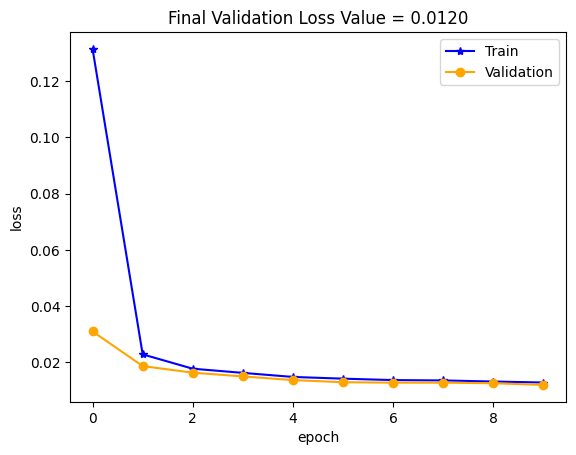

In [20]:
train(model, device, train_dataloader, valid_dataloader, lossfun, optimizer, scheduler, epoch_number=10, 
          save_model=False, model_name='Unknown', visualization=True)

In [21]:
# model = torch.load('/kaggle/input/trained-model/First_model_Final_prject.pth')

In [26]:
# torch.save(model, 'base_model_Final_prject.pth') # Save model parameters to file

In [23]:
def intensity_windowing(tensor, window_min, window_max, output_min=0, output_max=1):

    # Clip the tensor values to the window range
    clipped_tensor = torch.clamp(tensor, window_min, window_max)
    
    # Normalize the clipped tensor to the range [0, 1]
    normalized_tensor = (clipped_tensor - window_min) / (window_max - window_min)
    
    # Scale the normalized tensor to the output range [output_min, output_max]
    scaled_tensor = normalized_tensor * (output_max - output_min) + output_min
    
    return scaled_tensor


In [24]:
from torchmetrics.functional.image import peak_signal_noise_ratio
from torchmetrics.image import StructuralSimilarityIndexMeasure

PSNR_value_total = []
ssim_value_total = []
for x , target in test_dataloader:
    preds = model(x.to(device)).cpu().detach()
    PSNR_value = peak_signal_noise_ratio(preds , target)
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
    ssim_value = ssim(preds, target)
    PSNR_value_total.append(PSNR_value)
    ssim_value_total.append(ssim_value)
    
PSNR_value = np.mean(np.array(PSNR_value_total))
ssim_value = np.mean(np.array(ssim_value_total))
print(f'PSNR = {PSNR_value:.4f}')
print(f'SSIM = {ssim_value:.4f}')

PSNR = 38.8939
SSIM = 0.8968


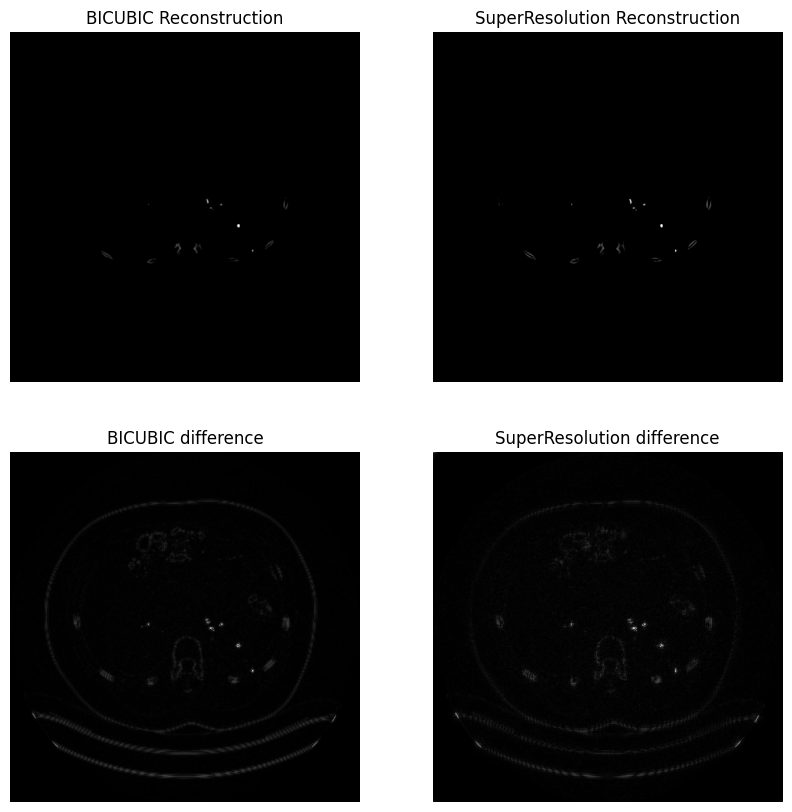

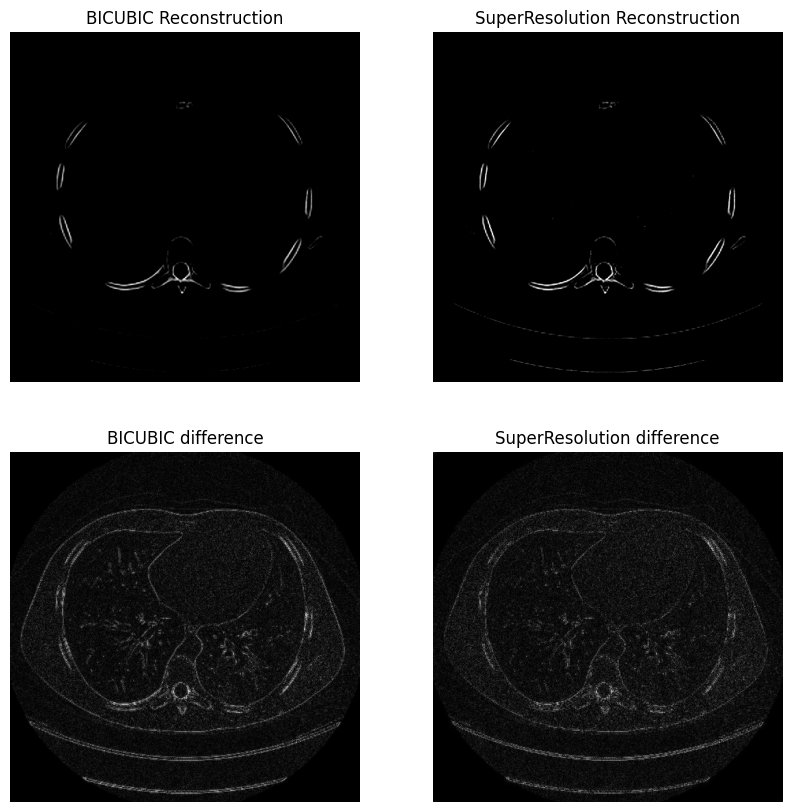

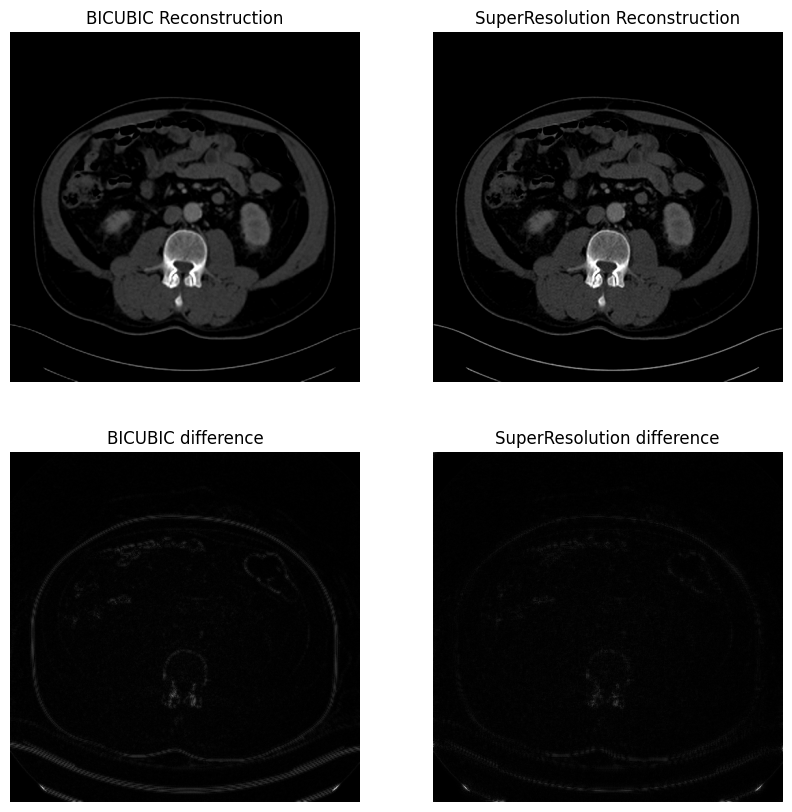

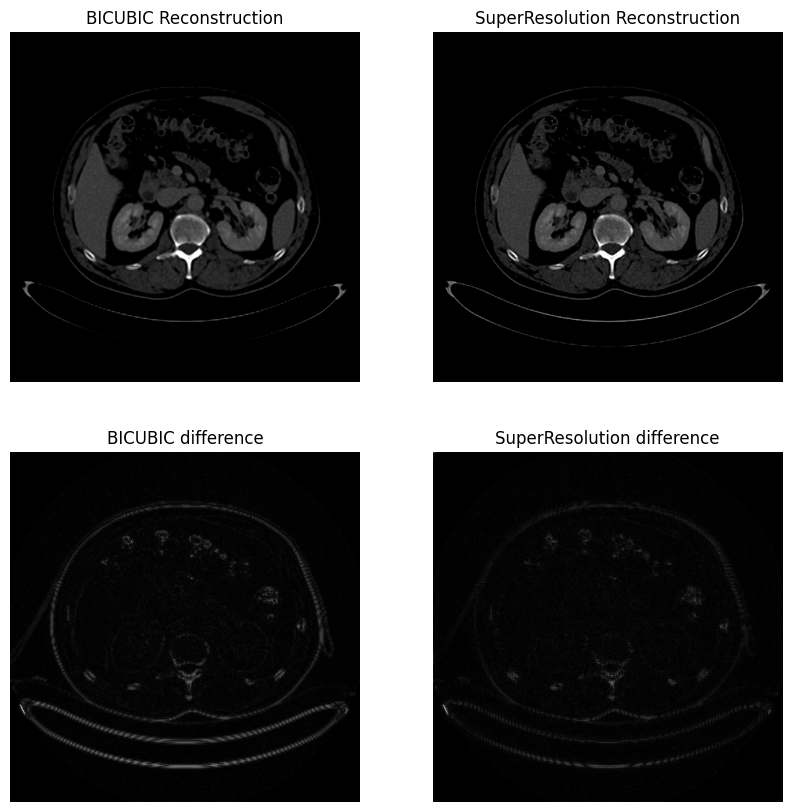

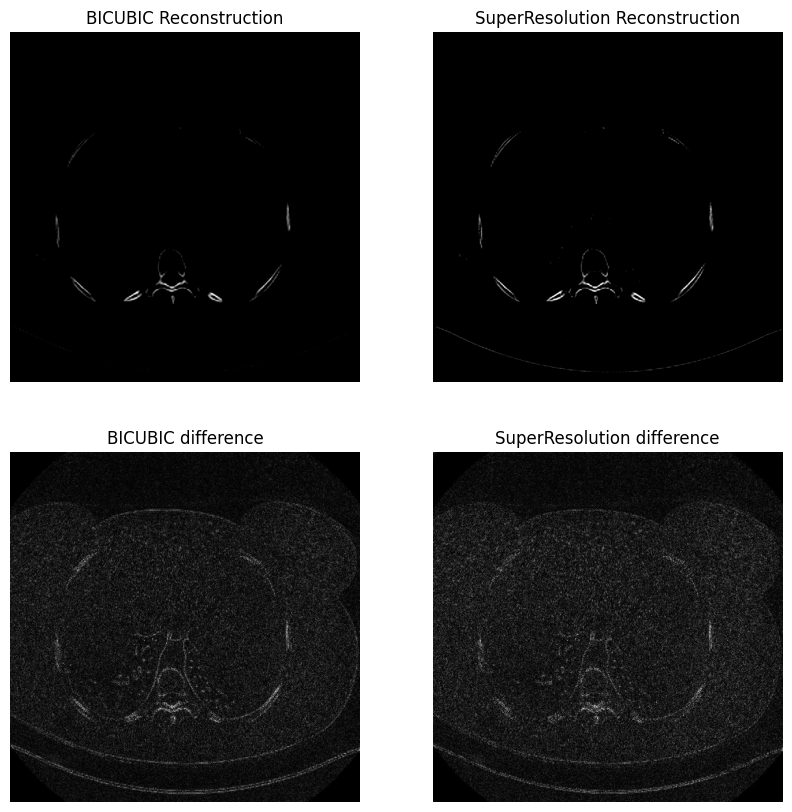

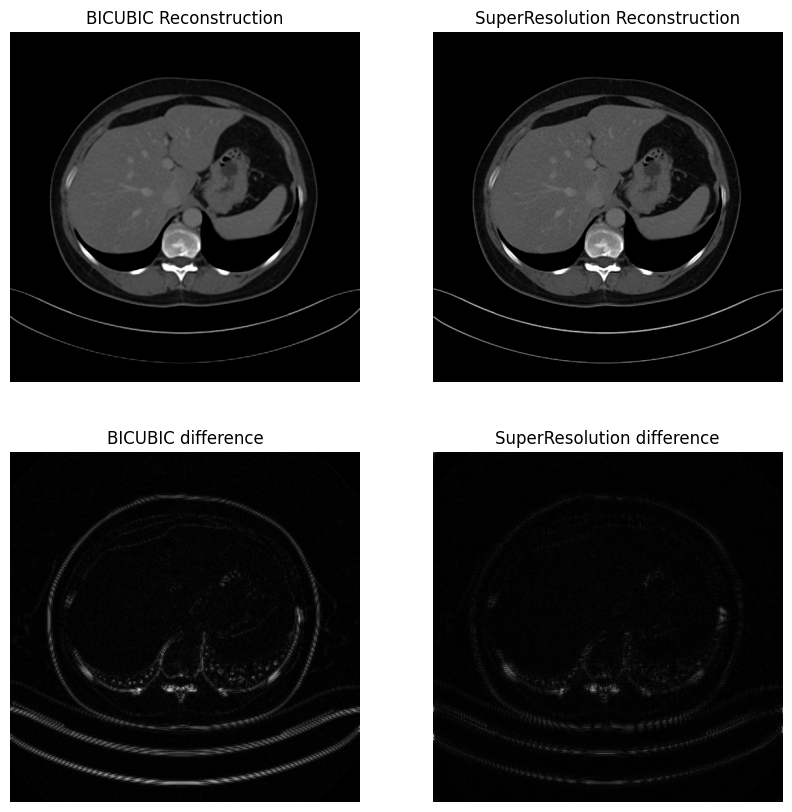

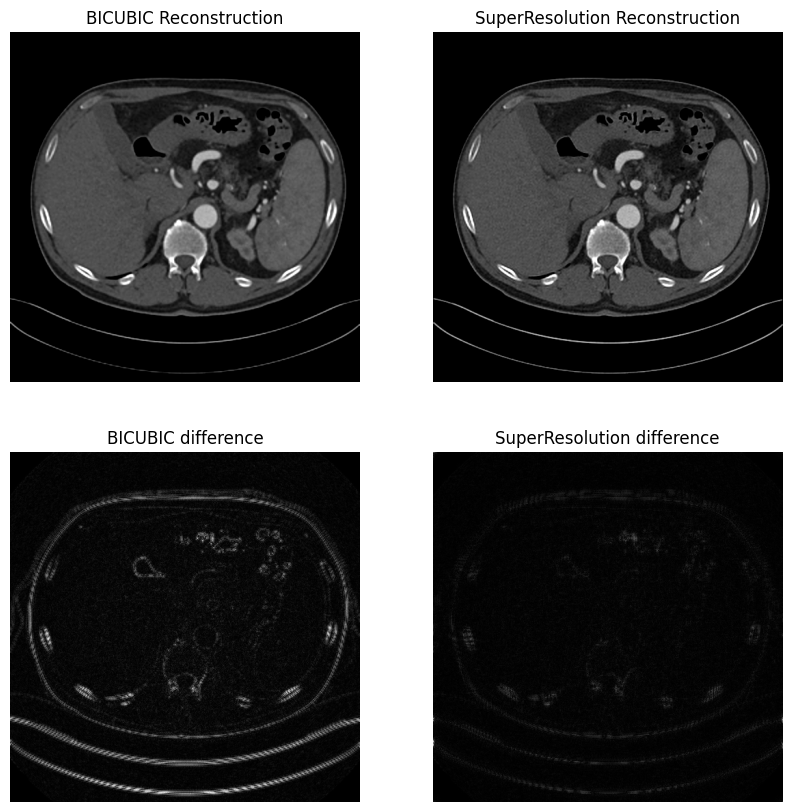

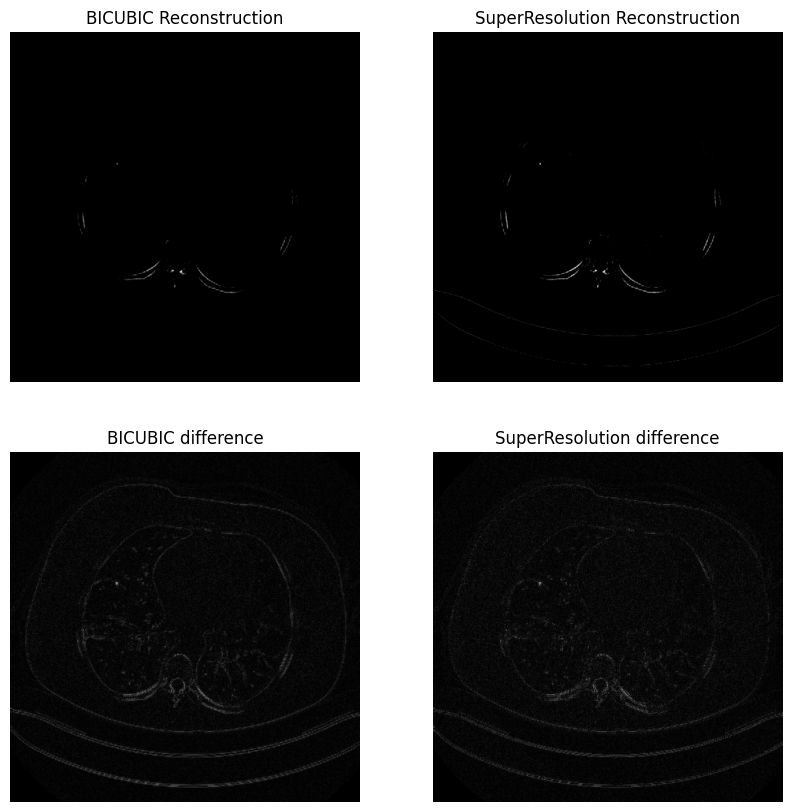

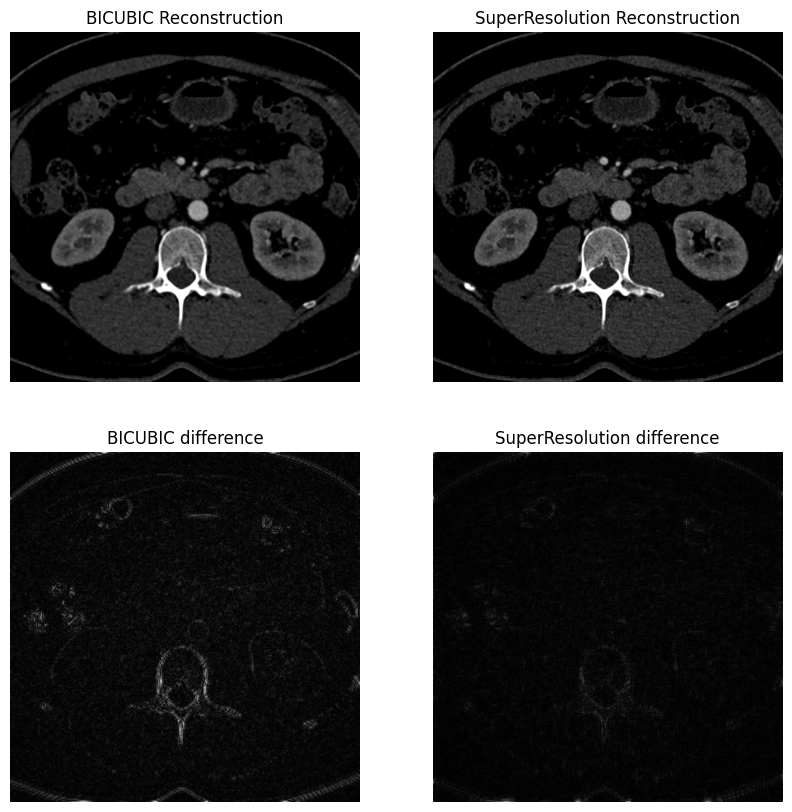

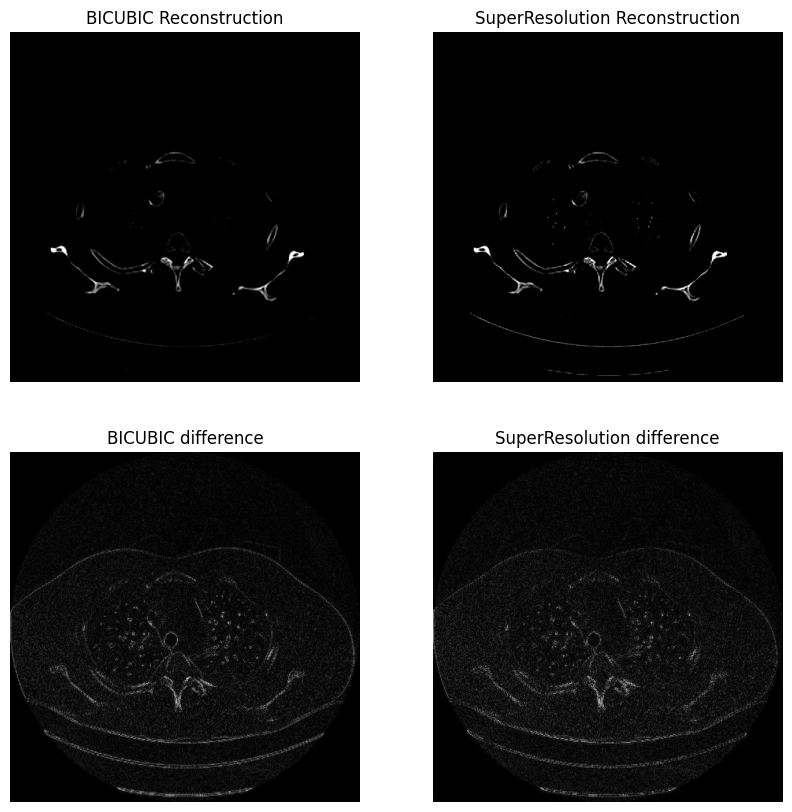

In [25]:
sample = 0
for x , y in test_dataloader:
    if sample < 10:
        sample +=1
        output = model(x.to(device)).cpu().detach()
        inpt = x
        preds = output
        target = y

        Resizer = transforms.Resize((512,512) , interpolation=Image.BICUBIC, antialias=True)
        BICUBIC_image = Resizer(inpt)

        BICUBIC_diff = abs(BICUBIC_image - target).squeeze().numpy()
        SuperResolution_diff = abs(preds - target).squeeze().numpy()

        BICUBIC_corrected = intensity_windowing(BICUBIC_image, window_min = 0.4, window_max = 0.7)
        preds_corrected = intensity_windowing(preds, window_min = 0.4, window_max = 0.7)

        plt.figure(figsize = (10,10))
        plt.subplot(2,2,1)
        plt.imshow(BICUBIC_corrected.squeeze(),cmap = 'gray')
        plt.axis('off')
        plt.title('BICUBIC Reconstruction')

        plt.subplot(2,2,2)
        plt.imshow(preds_corrected.squeeze(),cmap = 'gray')
        plt.axis('off')
        plt.title('SuperResolution Reconstruction')

        plt.subplot(2,2,3)
        plt.imshow(BICUBIC_diff,cmap = 'gray')
        plt.axis('off')
        plt.title('BICUBIC difference')

        plt.subplot(2,2,4)
        plt.imshow(SuperResolution_diff,cmap = 'gray')
        plt.axis('off')
        plt.title('SuperResolution difference')
        plt.show()
